In [38]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.append(os.path.abspath("src"))

from lab5.constants import FS_SPIKE
from lab5.figures import apply_style, compute_global_ylim, save_figure, set_shared_limits
from lab5.io_mat import load_mat
from lab5.lfp import LFP_spectrum
from lab5.paths import DATA_DIR, PLOTS_FINAL_DIR
from lab5.signal import plotSignal
from lab5.spikes import (
    align_spike_times,
    convert_waveforms_to_uv,
    ensure_waveforms_2d,
    plotSpikes,
)


apply_style()

RAW_MAT_PATH = DATA_DIR / "Ch01 walk daniil.mat"
LFP_MAT_PATH = DATA_DIR / "LFP_data.mat"


# Part 1 — Signal filtering


(PosixPath('/Users/ilya/Downloads/neurolab-5/plots/final/part1_ch01_walk_daniil_signal.png'),)

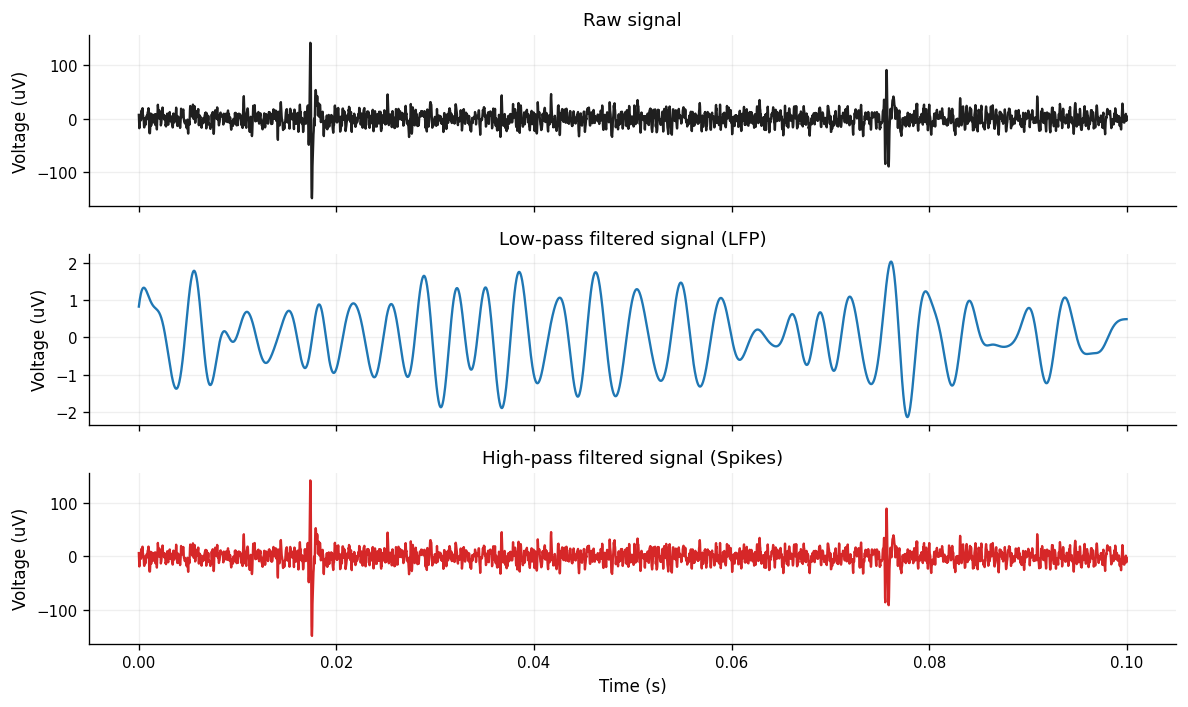

In [39]:
mat = load_mat(RAW_MAT_PATH)
spk01 = mat["SPK01"]
raw = spk01[:, 0]
fig, _ = plotSignal(raw, t_start=0.0, t_duration=0.1)
save_figure(fig, "part1_ch01_walk_daniil_signal")


The raw extracellular signal contains a mixture of slow fluctuations, fast transients, and background noise. In the unfiltered trace, action potentials appear as brief, high-amplitude deflections embedded within lower-amplitude, slower variations, making it difficult to isolate specific components of neural activity.

Applying a low-pass filter preserves the slow components of the signal while attenuating rapid voltage changes. As a result, sharp spike waveforms are removed and the signal becomes dominated by smooth, oscillatory fluctuations corresponding to local field potentials (LFPs), which reflect the summed synaptic and dendritic activity of nearby neuronal populations.

In contrast, applying a high-pass filter removes the slow fluctuations and emphasizes fast transients. This filtering isolates the brief, high-frequency components associated with action potentials, allowing individual spikes to be clearly distinguished from the background signal.

Overall, filtering decomposes the original raw signal into functionally distinct components: low-frequency activity related to population-level synaptic dynamics and high-frequency activity corresponding to single-neuron spiking.

# Part 2 — Spike waveforms


In [40]:
# Part 2 dataset selection
P2_STAND_PATH = DATA_DIR / "Ch20 stand Carmel.mat"
P2_WALK_PATH = DATA_DIR / "Ch20 walk Carmel.mat"
P2_PERSON_A_PATH = DATA_DIR / "Ch01 stand Ohad.mat"
P2_PERSON_B_PATH = DATA_DIR / "Ch01 stand Sagi.mat"

P2_STAND_WF_KEYS = ("SPK20a_wf", "SPK20b_wf")
P2_PERSON_WF_KEYS = ("SPK01a_wf", "SPK01b_wf", "SPK01c_wf")


In [41]:
def select_best_unit_waveforms(mat, wf_keys):
    candidates = []
    for wf_key in wf_keys:
        if wf_key not in mat:
            continue
        times_key = wf_key.replace("_wf", "")
        if times_key not in mat:
            continue
        spike_times = np.asarray(mat[times_key]).reshape(-1)
        wf, wf_info = ensure_waveforms_2d(mat[wf_key], n_spikes_expected=spike_times.size)
        spike_times, wf, time_info = align_spike_times(spike_times, wf)
        wf_uv, unit_info = convert_waveforms_to_uv(wf)
        candidates.append(
            {
                "wf_key": wf_key,
                "unit_key": times_key,
                "n_spikes": wf_uv.shape[1],
                "waveforms": wf_uv,
                "info": {**wf_info, **time_info, **unit_info},
            }
        )

    if not candidates:
        raise ValueError("No waveform units found for the provided keys.")

    best = max(candidates, key=lambda item: item["n_spikes"])
    if len(candidates) > 1:
        summary = ", ".join(f"{item['unit_key']}={item['n_spikes']}" for item in candidates)
        print(f"Selecting most active unit: {best['unit_key']} ({summary})")
    return best["waveforms"], best


def extract_unit_waveforms(mat, unit_key):
    wf_key = unit_key if unit_key.endswith("_wf") else f"{unit_key}_wf"
    if wf_key not in mat:
        raise KeyError(f"Waveform key {wf_key} not found.")
    times_key = wf_key.replace("_wf", "")
    if times_key not in mat:
        raise KeyError(f"Spike-time key {times_key} not found.")
    spike_times = np.asarray(mat[times_key]).reshape(-1)
    wf, _ = ensure_waveforms_2d(mat[wf_key], n_spikes_expected=spike_times.size)
    spike_times, wf, _ = align_spike_times(spike_times, wf)
    wf_uv, _ = convert_waveforms_to_uv(wf)
    return wf_uv


def mean_waveform(waveforms):
    return np.mean(waveforms, axis=1)


def waveform_corr(a, b):
    if a.shape[0] != b.shape[0]:
        n = min(a.shape[0], b.shape[0])
        a = a[:n]
        b = b[:n]
    return float(np.corrcoef(a, b)[0, 1])


def unit_means(mat, wf_keys):
    means = {}
    for wf_key in wf_keys:
        unit_key = wf_key.replace("_wf", "")
        if wf_key not in mat:
            continue
        means[unit_key] = mean_waveform(extract_unit_waveforms(mat, unit_key))
    return means


def best_match_units(means_a, means_b):
    best = None
    for unit_a, mean_a in means_a.items():
        for unit_b, mean_b in means_b.items():
            corr = waveform_corr(mean_a, mean_b)
            if best is None or corr > best["corr"]:
                best = {"unit_a": unit_a, "unit_b": unit_b, "corr": corr}
    if best is None:
        raise ValueError("No overlapping units for best-match comparison.")
    return best


Selecting most active unit: SPK20a (SPK20a=578, SPK20b=470)
Selecting most active unit: SPK20a (SPK20a=700, SPK20b=357)
Selecting most active unit: SPK01c (SPK01a=350, SPK01b=16, SPK01c=489)
Selecting most active unit: SPK01a (SPK01a=482, SPK01b=348, SPK01c=23)
Condition comparison counts: SPK20a 578 SPK20a 700 ylim (np.float64(-416110.9924316406), np.float64(344598.13435872394))
People comparison counts: SPK01c 489 SPK01a 482 ylim (np.float64(-271288.55387369794), np.float64(232810.97412109375))
SPK01a vs SPK01a mean corr: 0.7046
Best-match mean corr: 0.9999 (SPK01a vs SPK01b)


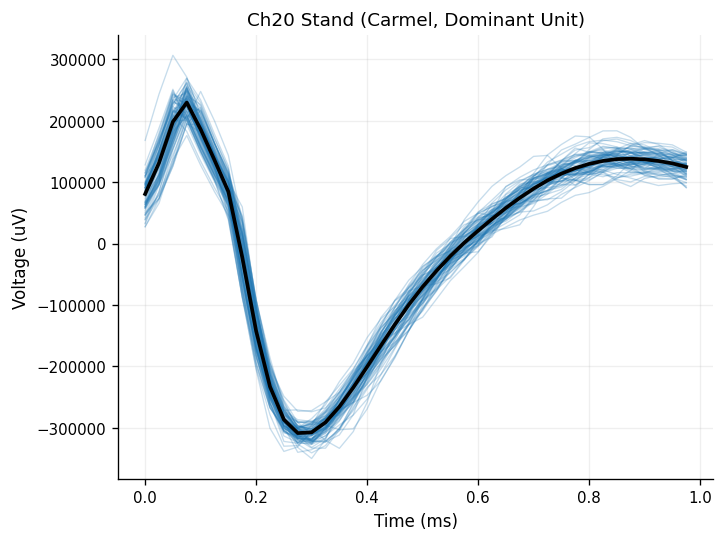

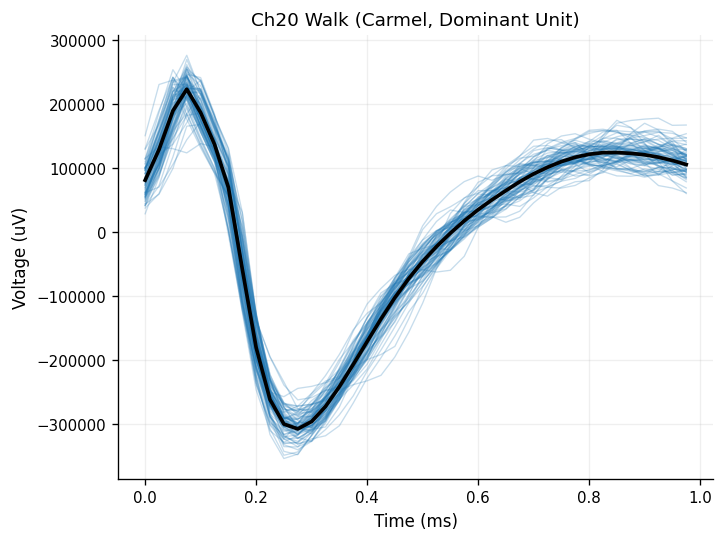

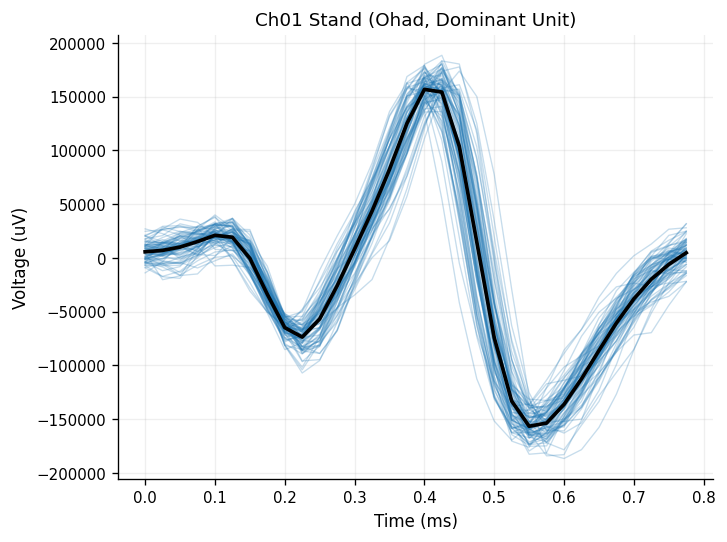

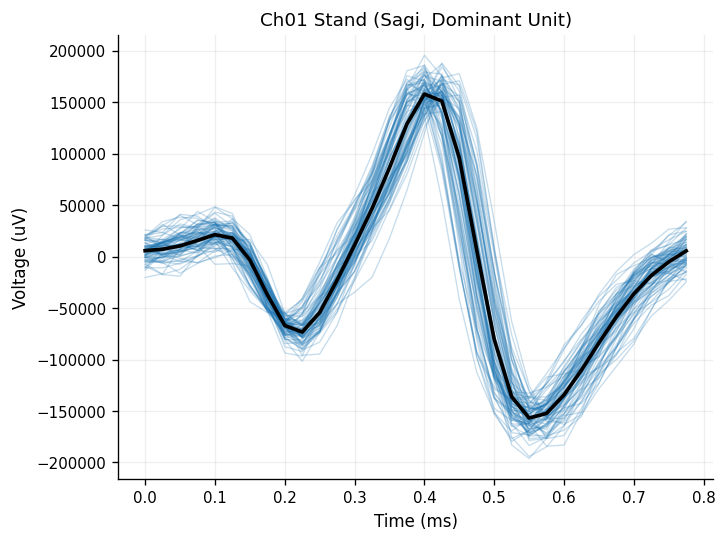

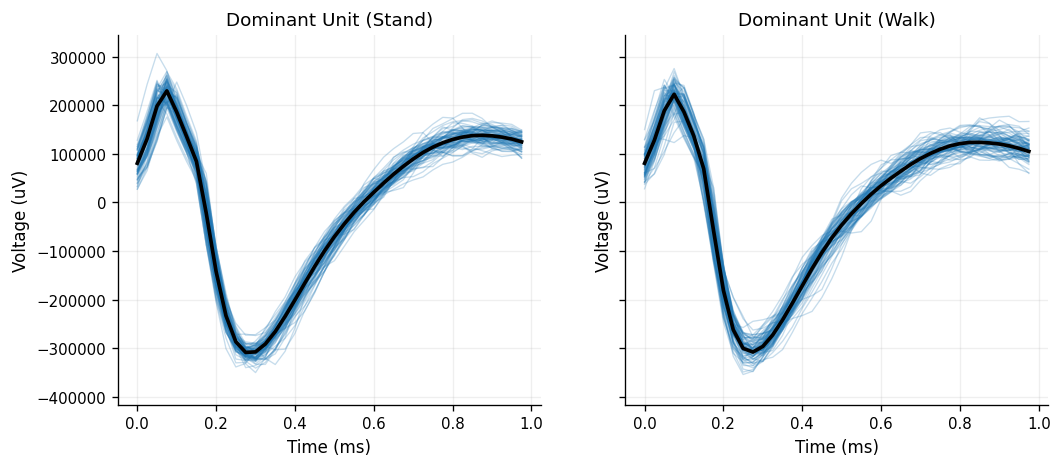

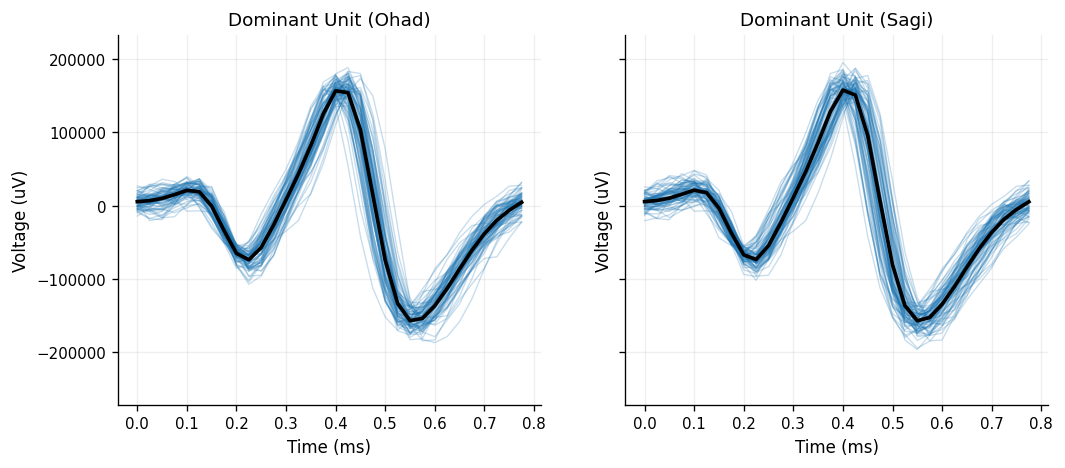

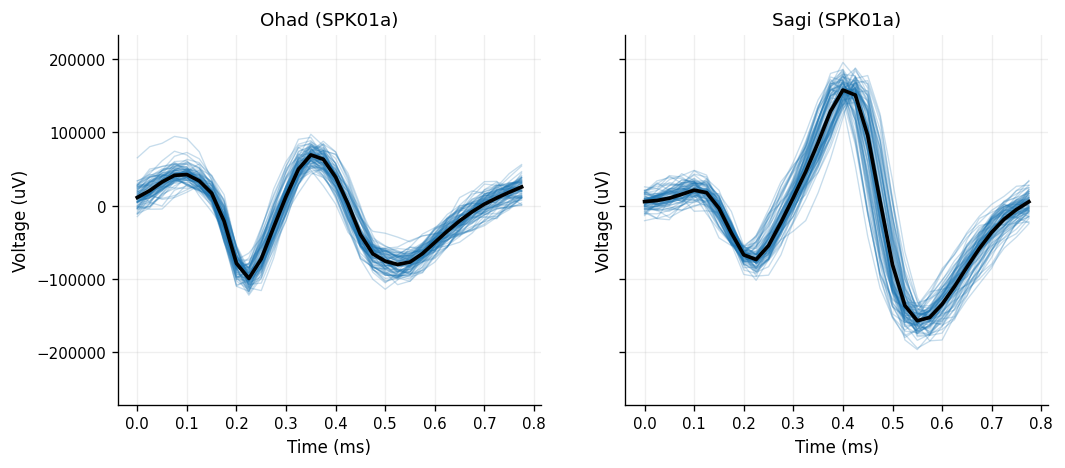

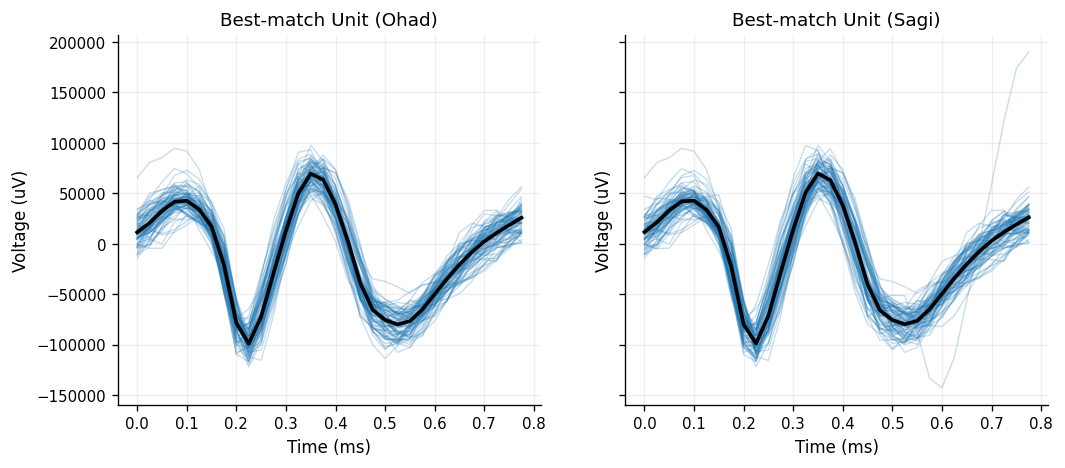

In [42]:
stand_mat = load_mat(P2_STAND_PATH)
walk_mat = load_mat(P2_WALK_PATH)
person_a_mat = load_mat(P2_PERSON_A_PATH)
person_b_mat = load_mat(P2_PERSON_B_PATH)

wf_stand, best_stand = select_best_unit_waveforms(stand_mat, P2_STAND_WF_KEYS)
wf_walk, best_walk = select_best_unit_waveforms(walk_mat, P2_STAND_WF_KEYS)
wf_person_a, best_person_a = select_best_unit_waveforms(person_a_mat, P2_PERSON_WF_KEYS)
wf_person_b, best_person_b = select_best_unit_waveforms(person_b_mat, P2_PERSON_WF_KEYS)

n_plot = 80
fs = FS_SPIKE
units_label = "uV"

# Figure set A: random waveforms from channel + mean
fig, _ = plotSpikes(
    wf_stand,
    n=n_plot,
    fs=fs,
    title="Ch20 Stand (Carmel, Dominant Unit)",
    units_label=units_label,
)
save_figure(fig, f"part2_ch20_stand_carmel_n{n_plot}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(
    wf_walk,
    n=n_plot,
    fs=fs,
    title="Ch20 Walk (Carmel, Dominant Unit)",
    units_label=units_label,
)
save_figure(fig, f"part2_ch20_walk_carmel_n{n_plot}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(
    wf_person_a,
    n=n_plot,
    fs=fs,
    title="Ch01 Stand (Ohad, Dominant Unit)",
    units_label=units_label,
)
save_figure(fig, f"part2_ch01_stand_ohad_n{n_plot}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(
    wf_person_b,
    n=n_plot,
    fs=fs,
    title="Ch01 Stand (Sagi, Dominant Unit)",
    units_label=units_label,
)
save_figure(fig, f"part2_ch01_stand_sagi_n{n_plot}_fs{int(fs)}_{units_label}")

# Figure set B: condition comparison (Stand vs Walk)
ylim_cond = compute_global_ylim([wf_stand.ravel(), wf_walk.ravel()])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plotSpikes(
    wf_stand,
    n=n_plot,
    fs=fs,
    ax=axes[0],
    title="Dominant Unit (Stand)",
    ylim=ylim_cond,
    units_label=units_label,
)
plotSpikes(
    wf_walk,
    n=n_plot,
    fs=fs,
    ax=axes[1],
    title="Dominant Unit (Walk)",
    ylim=ylim_cond,
    units_label=units_label,
)
set_shared_limits(axes, ylim=ylim_cond)
save_figure(fig, f"part2_ch20_stand_walk_compare_n{n_plot}_fs{int(fs)}_{units_label}")

# Figure set C: people comparison (dominant unit)
ylim_people = compute_global_ylim([wf_person_a.ravel(), wf_person_b.ravel()])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plotSpikes(
    wf_person_a,
    n=n_plot,
    fs=fs,
    ax=axes[0],
    title="Dominant Unit (Ohad)",
    ylim=ylim_people,
    units_label=units_label,
)
plotSpikes(
    wf_person_b,
    n=n_plot,
    fs=fs,
    ax=axes[1],
    title="Dominant Unit (Sagi)",
    ylim=ylim_people,
    units_label=units_label,
)
set_shared_limits(axes, ylim=ylim_people)
save_figure(fig, f"part2_ch01_ohad_sagi_compare_n{n_plot}_fs{int(fs)}_{units_label}")

# Figure set D: same unit key comparison (SPK01a)
spk01a_ok = True
try:
    wf_person_a_spk01a = extract_unit_waveforms(person_a_mat, "SPK01a")
    wf_person_b_spk01a = extract_unit_waveforms(person_b_mat, "SPK01a")
except KeyError as exc:
    spk01a_ok = False
    print(f"SPK01a comparison skipped: {exc}")

if spk01a_ok:
    ylim_spk01a = compute_global_ylim([wf_person_a_spk01a.ravel(), wf_person_b_spk01a.ravel()])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    plotSpikes(
        wf_person_a_spk01a,
        n=n_plot,
        fs=fs,
        ax=axes[0],
        title="Ohad (SPK01a)",
        ylim=ylim_spk01a,
        units_label=units_label,
    )
    plotSpikes(
        wf_person_b_spk01a,
        n=n_plot,
        fs=fs,
        ax=axes[1],
        title="Sagi (SPK01a)",
        ylim=ylim_spk01a,
        units_label=units_label,
    )
    set_shared_limits(axes, ylim=ylim_spk01a)
    save_figure(fig, f"part2_ch01_ohad_sagi_spk01a_compare_n{n_plot}_fs{int(fs)}_{units_label}")

# Figure set E: best-match comparison by mean correlation
means_a = unit_means(person_a_mat, P2_PERSON_WF_KEYS)
means_b = unit_means(person_b_mat, P2_PERSON_WF_KEYS)
best_match = best_match_units(means_a, means_b)
wf_best_a = extract_unit_waveforms(person_a_mat, best_match["unit_a"])
wf_best_b = extract_unit_waveforms(person_b_mat, best_match["unit_b"])

ylim_best = compute_global_ylim([wf_best_a.ravel(), wf_best_b.ravel()])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plotSpikes(
    wf_best_a,
    n=n_plot,
    fs=fs,
    ax=axes[0],
    title="Best-match Unit (Ohad)",
    ylim=ylim_best,
    units_label=units_label,
)
plotSpikes(
    wf_best_b,
    n=n_plot,
    fs=fs,
    ax=axes[1],
    title="Best-match Unit (Sagi)",
    ylim=ylim_best,
    units_label=units_label,
)
set_shared_limits(axes, ylim=ylim_best)
save_figure(fig, f"part2_ch01_ohad_sagi_bestmatch_n{n_plot}_fs{int(fs)}_{units_label}")

print(
    "Condition comparison counts:",
    best_stand["unit_key"],
    wf_stand.shape[1],
    best_walk["unit_key"],
    wf_walk.shape[1],
    "ylim",
    ylim_cond,
)
print(
    "People comparison counts:",
    best_person_a["unit_key"],
    wf_person_a.shape[1],
    best_person_b["unit_key"],
    wf_person_b.shape[1],
    "ylim",
    ylim_people,
)
if spk01a_ok:
    corr_spk01a = waveform_corr(
        mean_waveform(wf_person_a_spk01a),
        mean_waveform(wf_person_b_spk01a),
    )
    print(f"SPK01a vs SPK01a mean corr: {corr_spk01a:.4f}")
print(
    f"Best-match mean corr: {best_match['corr']:.4f}"
    f" ({best_match['unit_a']} vs {best_match['unit_b']})"
)


Individual waveforms cluster tightly with moderate amplitude spread; the mean waveform captures the central shape well.
Stand vs Walk on Ch20 (Carmel): waveform shape and timing are highly similar; Walk shows a slightly deeper negative trough with comparable repolarization.
Ohad vs Sagi on Ch01 (Stand): overall shape is consistent across sorters; Sagi shows slightly larger peak-to-peak amplitude and broader variability.

# Part 3 — Firing rate


In [43]:
# Part 3 imports + configuration
from lab5.constants import BIN_SIZES_S, FS_SPIKE, PREFERRED_BIN_S
from lab5.plot_style import COLORS
from lab5.rates import (
    binned_firing_rate,
    compare_rate_samples,
    extract_stages,
    extract_units,
    infer_spike_times_seconds,
    nonoverlap_edges,
    plot_firing_rate,
    spike_train_counts,
    validate_spike_times,
)

P3_STAND_PATH = DATA_DIR / "Ch20 stand Carmel.mat"
P3_WALK_PATH = DATA_DIR / "Ch20 walk Carmel.mat"
P3_PERSON_A_PATH = DATA_DIR / "Ch01 stand Ohad.mat"
P3_PERSON_B_PATH = DATA_DIR / "Ch01 stand Sagi.mat"

P3_UNIT_KEY = "SPK20a"
P3_PERSON_A_UNIT_KEY = "SPK01a"
P3_PERSON_B_UNIT_KEY = "SPK01b"

def _fmt_bin(bin_s: float) -> str:
    return str(bin_s).replace(".", "p")


In [44]:
def load_unit_times(mat_path, unit_key, *, Fs=FS_SPIKE):
    mat = load_mat(mat_path)
    units = extract_units(mat)
    if not units:
        raise ValueError(f"No spike-time units found in {mat_path}")
    if unit_key not in units:
        fallback = sorted(units.keys())[0]
        print(f"Unit key {unit_key} not found in {mat_path.name}; using {fallback}")
        unit_key = fallback
    spike_times = units[unit_key]

    stages = extract_stages(mat)
    start_s = stop_s = None
    if "recording" in stages:
        start_s, stop_s = stages["recording"][0]

    spike_times_s, info = infer_spike_times_seconds(
        spike_times,
        Fs=Fs,
        duration_s=None if stop_s is None else (stop_s - start_s),
    )
    if start_s is None:
        start_s = 0.0
    if stop_s is None or not np.isfinite(stop_s):
        stop_s = float(np.nanmax(spike_times_s))

    spike_times_s = validate_spike_times(spike_times_s, start_s=start_s, stop_s=stop_s)
    duration_s = stop_s - start_s

    meta = {
        "unit_key": unit_key,
        "start_s": float(start_s),
        "stop_s": float(stop_s),
        "duration_s": float(duration_s),
        **info,
    }
    return spike_times_s, meta

stand_times, stand_meta = load_unit_times(P3_STAND_PATH, P3_UNIT_KEY)
walk_times, walk_meta = load_unit_times(P3_WALK_PATH, P3_UNIT_KEY)
person_a_times, person_a_meta = load_unit_times(P3_PERSON_A_PATH, P3_PERSON_A_UNIT_KEY)
person_b_times, person_b_meta = load_unit_times(P3_PERSON_B_PATH, P3_PERSON_B_UNIT_KEY)

print("Stand meta:", stand_meta)
print("Walk meta:", walk_meta)
print("Person A meta:", person_a_meta)
print("Person B meta:", person_b_meta)


Stand meta: {'unit_key': 'SPK20a', 'start_s': 0.001375, 'stop_s': 119.998375, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.946825}
Walk meta: {'unit_key': 'SPK20a', 'start_s': 0.00045, 'stop_s': 119.99745, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.7647}
Person A meta: {'unit_key': 'SPK01a', 'start_s': 0.0023, 'stop_s': 119.9993, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.97575}
Person B meta: {'unit_key': 'SPK01b', 'start_s': 0.0023, 'stop_s': 119.9993, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.97575}


(PosixPath('/Users/ilya/Downloads/neurolab-5/plots/final/part3_bin_demo_SPK20a_bins_0p05_0p2_1p0_5p0_fs40000.png'),)

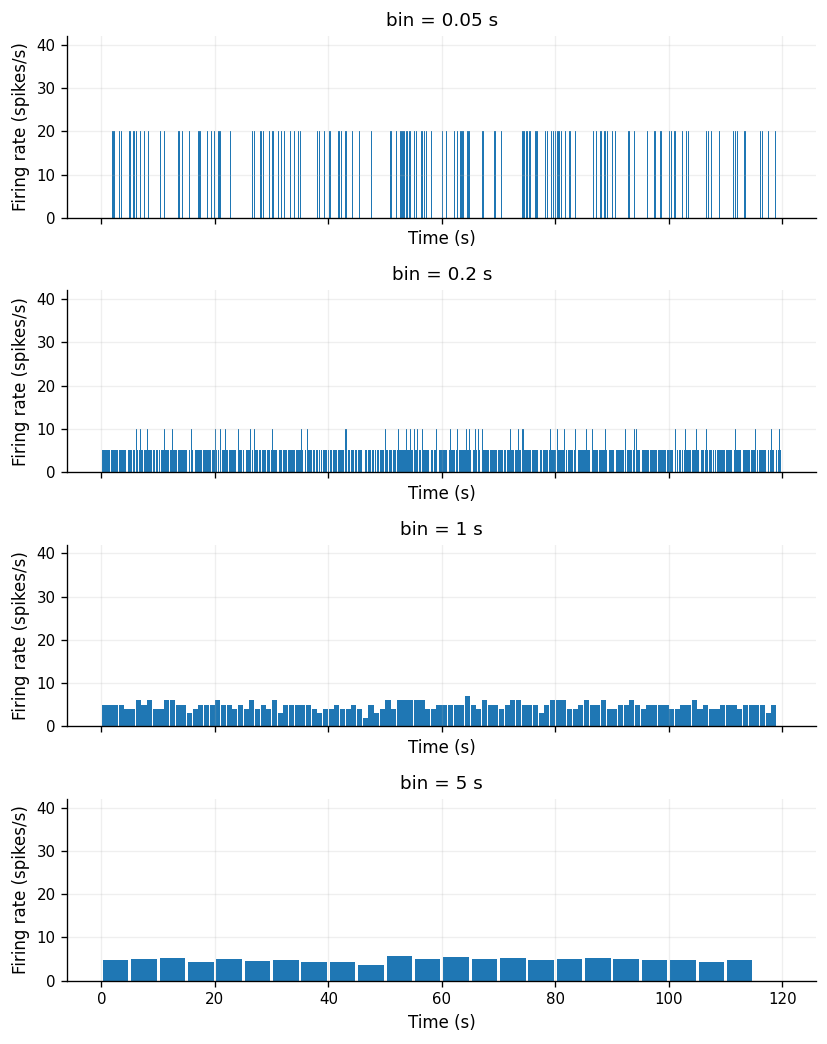

In [45]:
# Bin-size (single representative unit)
bin_sizes = BIN_SIZES_S
rates_per_bin = []
for bin_s in bin_sizes:
    t_s, rate_hz, _, _ = binned_firing_rate(
        stand_times,
        start_s=stand_meta["start_s"],
        stop_s=stand_meta["stop_s"],
        bin_s=bin_s,
    )
    rates_per_bin.append((bin_s, t_s, rate_hz))

max_rate = max((rate.max() for _, _, rate in rates_per_bin if rate.size), default=1.0)

fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(7, 2.2 * len(bin_sizes)), sharex=True)
if len(bin_sizes) == 1:
    axes = [axes]
for ax, (bin_s, t_s, rate_hz) in zip(axes, rates_per_bin):
    ax.bar(t_s, rate_hz, width=0.9 * bin_s, color=COLORS["trace"], align="center")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Firing rate (spikes/s)")
    ax.set_title(f"bin = {bin_s:.3g} s")
    ax.set_ylim(0, max_rate * 1.05)

fig.tight_layout()
bin_label = "_".join(_fmt_bin(b) for b in bin_sizes)
save_figure(fig, f"part3_bin_demo_{stand_meta['unit_key']}_bins_{bin_label}_fs{int(FS_SPIKE)}")


Stand vs Walk stats: {'method': 'mannwhitney_u', 'n_a': 599, 'n_b': 599, 'mean_a': 4.816360601001669, 'mean_b': 5.843071786310517, 'mean_diff': -1.026711185308848, 'pvalue': 6.029189579074553e-10, 'comparison': 'stand_vs_walk', 'unit_key_a': 'SPK20a', 'unit_key_b': 'SPK20a', 'bin_s': 0.2}
Counts match (stand, histogram vs train): True


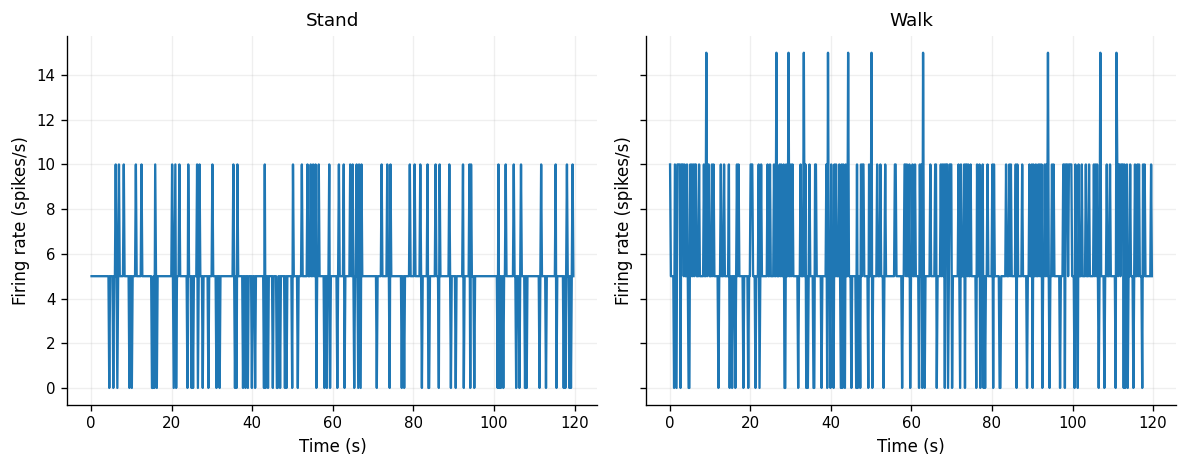

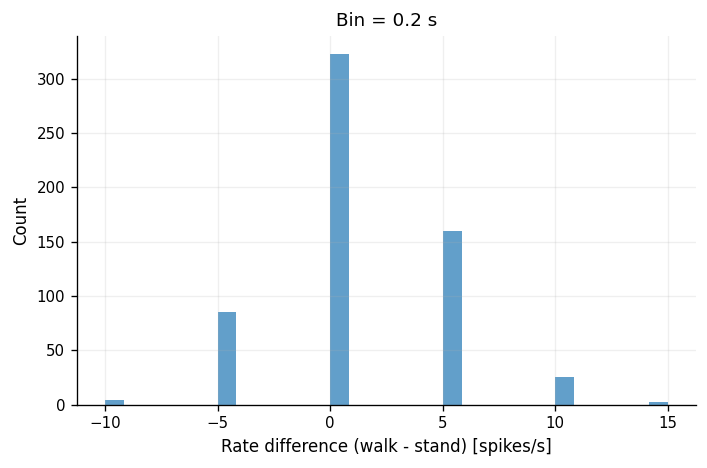

In [46]:
# Preferred bin size: stand vs walk comparison
bin_s = PREFERRED_BIN_S
t_stand, rate_stand, counts_stand, edges_stand = binned_firing_rate(
    stand_times,
    start_s=stand_meta["start_s"],
    stop_s=stand_meta["stop_s"],
    bin_s=bin_s,
)
t_walk, rate_walk, counts_walk, edges_walk = binned_firing_rate(
    walk_times,
    start_s=walk_meta["start_s"],
    stop_s=walk_meta["stop_s"],
    bin_s=bin_s,
)

ylim = compute_global_ylim([rate_stand, rate_walk])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_firing_rate(t_stand, rate_stand, ax=axes[0], title="Stand", ylim=ylim)
plot_firing_rate(t_walk, rate_walk, ax=axes[1], title="Walk", ylim=ylim)
set_shared_limits(axes, ylim=ylim)
fig.tight_layout()
save_figure(
    fig,
    f"part3_{stand_meta['unit_key']}_stand_walk_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

# Histogram of differences (walk - stand)
n_bins = min(rate_stand.size, rate_walk.size)
diffs = rate_walk[:n_bins] - rate_stand[:n_bins]
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(diffs, bins=30, color=COLORS["trace"], alpha=0.7)
ax.set_xlabel("Rate difference (walk - stand) [spikes/s]")
ax.set_ylabel("Count")
ax.set_title(f"Bin = {bin_s:.3g} s")
fig.tight_layout()
save_figure(
    fig,
    f"part3_{stand_meta['unit_key']}_walk_minus_stand_hist_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

result_sw = compare_rate_samples(rate_stand, rate_walk, method="mannwhitney")
result_sw["comparison"] = "stand_vs_walk"
result_sw["unit_key_a"] = stand_meta["unit_key"]
result_sw["unit_key_b"] = walk_meta["unit_key"]
result_sw["bin_s"] = float(bin_s)
print("Stand vs Walk stats:", result_sw)

# check: histogram counts vs spike-train counts
edges, effective_stop = nonoverlap_edges(stand_meta["start_s"], stand_meta["stop_s"], bin_s)
counts_train = spike_train_counts(
    stand_times,
    start_s=stand_meta["start_s"],
    stop_s=effective_stop,
    Fs=FS_SPIKE,
    bin_s=bin_s,
)
counts_hist = np.histogram(stand_times, bins=edges)[0]
print("Counts match (stand, histogram vs train):", np.array_equal(counts_hist, counts_train))


Ohad vs Sagi stats: {'method': 'mannwhitney_u', 'n_a': 599, 'n_b': 599, 'mean_a': 2.9131886477462436, 'mean_b': 2.8964941569282137, 'mean_diff': 0.016694490818029983, 'pvalue': 0.8768504447824349, 'comparison': 'ohad_vs_sagi', 'unit_key_a': 'SPK01a', 'unit_key_b': 'SPK01b', 'bin_s': 0.2}


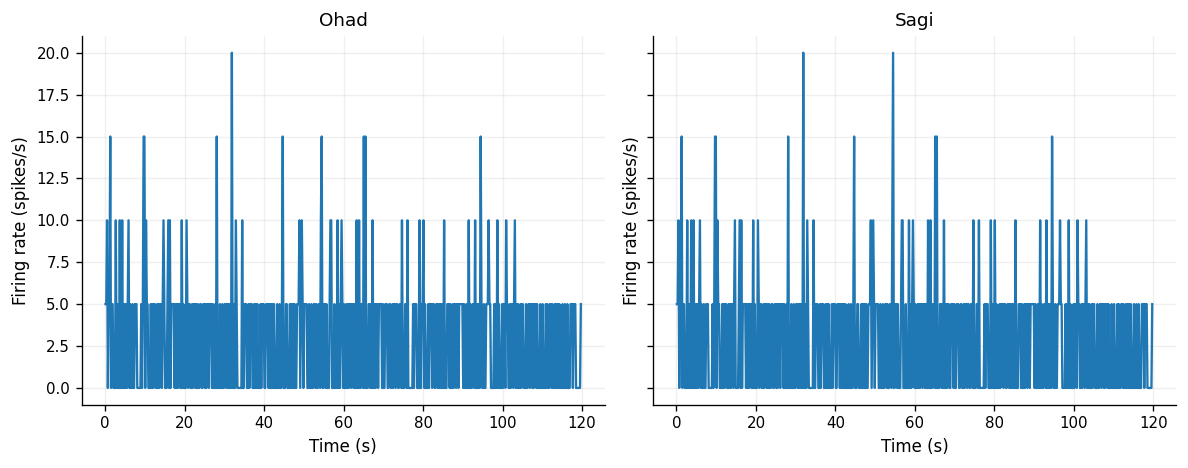

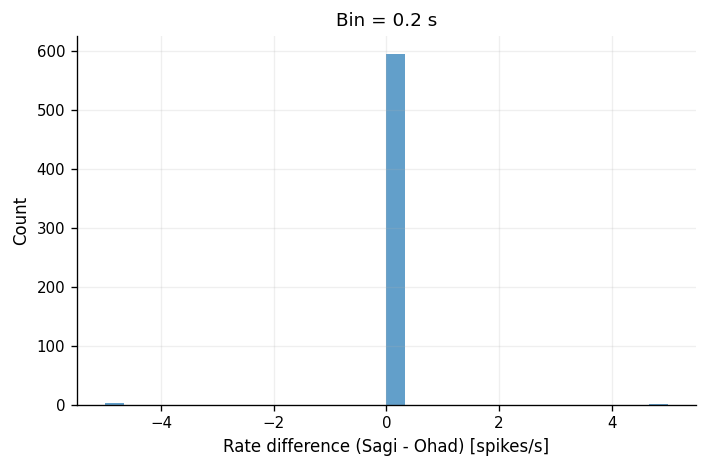

In [47]:
# Preferred bin size: people comparison
t_a, rate_a, counts_a, _ = binned_firing_rate(
    person_a_times,
    start_s=person_a_meta["start_s"],
    stop_s=person_a_meta["stop_s"],
    bin_s=bin_s,
)
t_b, rate_b, counts_b, _ = binned_firing_rate(
    person_b_times,
    start_s=person_b_meta["start_s"],
    stop_s=person_b_meta["stop_s"],
    bin_s=bin_s,
)

ylim_people = compute_global_ylim([rate_a, rate_b])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_firing_rate(t_a, rate_a, ax=axes[0], title="Ohad", ylim=ylim_people)
plot_firing_rate(t_b, rate_b, ax=axes[1], title="Sagi", ylim=ylim_people)
set_shared_limits(axes, ylim=ylim_people)
fig.tight_layout()
save_figure(
    fig,
    f"part3_ohad_{person_a_meta['unit_key']}_sagi_{person_b_meta['unit_key']}_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

n_bins = min(rate_a.size, rate_b.size)
diffs_people = rate_b[:n_bins] - rate_a[:n_bins]
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(diffs_people, bins=30, color=COLORS["trace"], alpha=0.7)
ax.set_xlabel("Rate difference (Sagi - Ohad) [spikes/s]")
ax.set_ylabel("Count")
ax.set_title(f"Bin = {bin_s:.3g} s")
fig.tight_layout()
save_figure(
    fig,
    f"part3_sagi_{person_b_meta['unit_key']}_minus_ohad_{person_a_meta['unit_key']}_hist_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

result_people = compare_rate_samples(rate_a, rate_b, method="mannwhitney")
result_people["comparison"] = "ohad_vs_sagi"
result_people["unit_key_a"] = person_a_meta["unit_key"]
result_people["unit_key_b"] = person_b_meta["unit_key"]
result_people["bin_s"] = float(bin_s)
print("Ohad vs Sagi stats:", result_people)


In [48]:
# Save Part 3 stats
import csv

stats_rows = [result_sw, result_people]
stats_path = PLOTS_FINAL_DIR / "part3_stats.csv"
with stats_path.open("w", newline="", encoding="utf-8") as handle:
    writer = csv.DictWriter(handle, fieldnames=sorted(stats_rows[0].keys()))
    writer.writeheader()
    writer.writerows(stats_rows)



In [56]:
# Part 3 — per-unit firing rates (each cell)
from math import ceil
import re

def per_unit_firing_rates(mat_path, *, bin_s, label, fs=FS_SPIKE, max_cols=2):
    if not mat_path.exists():
        print(f"Missing file for per-unit rates: {mat_path}")
        return None

    channel_match = re.search(r"Ch\d+", mat_path.name)
    channel_label = channel_match.group(0) if channel_match else ""
    mat = load_mat(mat_path)
    units = extract_units(mat)
    if not units:
        print(f"No units found in {mat_path.name}")
        return None

    stages = extract_stages(mat)
    start_s = stop_s = None
    if "recording" in stages:
        start_s, stop_s = stages["recording"][0]

    spike_seconds = {}
    max_stop = 0.0
    for unit_key, spike_times in units.items():
        times_s, _ = infer_spike_times_seconds(
            spike_times,
            Fs=fs,
            duration_s=None if stop_s is None else (stop_s - start_s),
        )
        times_s = validate_spike_times(times_s, start_s=None, stop_s=None)
        spike_seconds[unit_key] = times_s
        if times_s.size:
            max_stop = max(max_stop, float(np.nanmax(times_s)))

    if start_s is None:
        start_s = 0.0
    if stop_s is None or not np.isfinite(stop_s):
        stop_s = max_stop

    unit_keys = sorted(spike_seconds.keys())
    rates = []
    for unit_key in unit_keys:
        times_s = validate_spike_times(spike_seconds[unit_key], start_s=start_s, stop_s=stop_s)
        _, rate_hz, _, _ = binned_firing_rate(
            times_s,
            start_s=start_s,
            stop_s=stop_s,
            bin_s=bin_s,
        )
        rates.append(rate_hz)

    if not rates:
        print(f"No valid rates for {mat_path.name}")
        return None

    ylim = compute_global_ylim([r for r in rates if r.size])
    n_units = len(unit_keys)
    n_cols = min(max_cols, n_units)
    n_rows = int(ceil(n_units / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 2.2 * n_rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for i, (unit_key, rate_hz) in enumerate(zip(unit_keys, rates)):
        t_centers, _, _, _ = binned_firing_rate(
            validate_spike_times(spike_seconds[unit_key], start_s=start_s, stop_s=stop_s),
            start_s=start_s,
            stop_s=stop_s,
            bin_s=bin_s,
        )
        title = f"{channel_label} {unit_key}".strip()
        plot_firing_rate(t_centers, rate_hz, ax=axes[i], title=title, ylim=ylim)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    save_figure(fig, f"part3_all_units_{label}_bin{_fmt_bin(bin_s)}_fs{int(fs)}")

    print(f"Per-unit mean rates for {label}:")
    for unit_key, rate_hz in zip(unit_keys, rates):
        mean_rate = float(np.mean(rate_hz)) if rate_hz.size else float('nan')
        print(f"  {unit_key}: {mean_rate:.3f} spikes/s")
    plt.close(fig)
    return fig


Per-unit mean rates for ch01_walk_ilya:
  SPK01a: 1.728 spikes/s
  SPK01b: 2.471 spikes/s
  SPK01c: 1.444 spikes/s
  SPK01d: 0.659 spikes/s


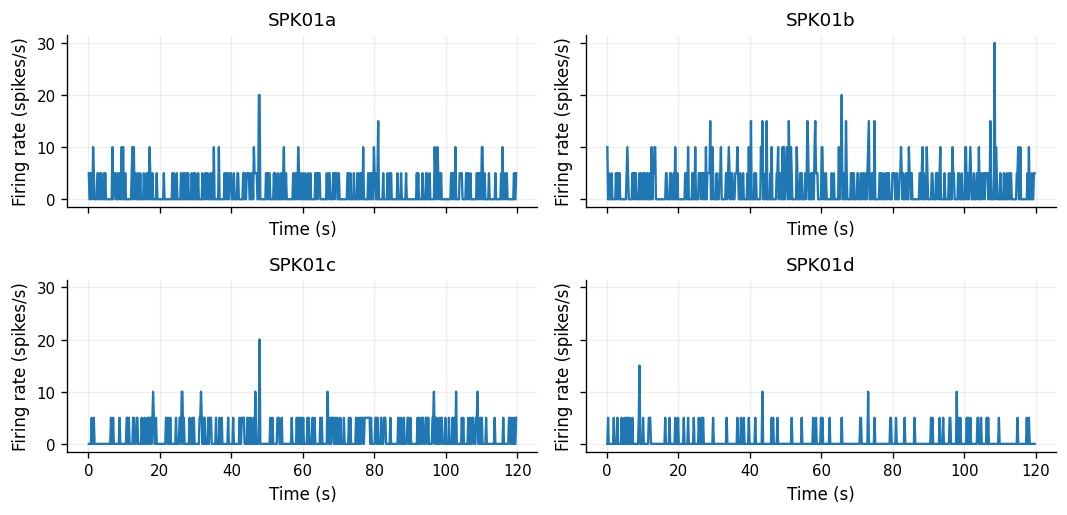

In [59]:
per_unit_firing_rates(DATA_DIR / "Ch01 walk Ilya.mat", bin_s=bin_s, label="ch01_walk_ilya")

Per-unit mean rates for ch01_walk_daniil.mat:
  SPK01a: 4.048 spikes/s
  SPK01b: 3.013 spikes/s


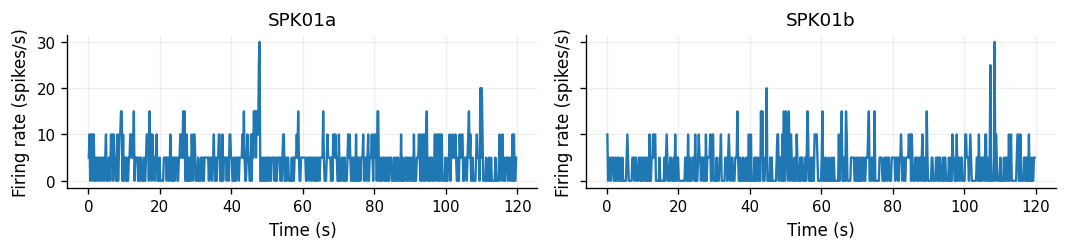

In [60]:
per_unit_firing_rates(DATA_DIR / "Ch01 walk daniil.mat", bin_s=bin_s, label="ch01_walk_daniil.mat")

# Part 4 — LFP spectrum


[<Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>,
 <Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>,
 <Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>]

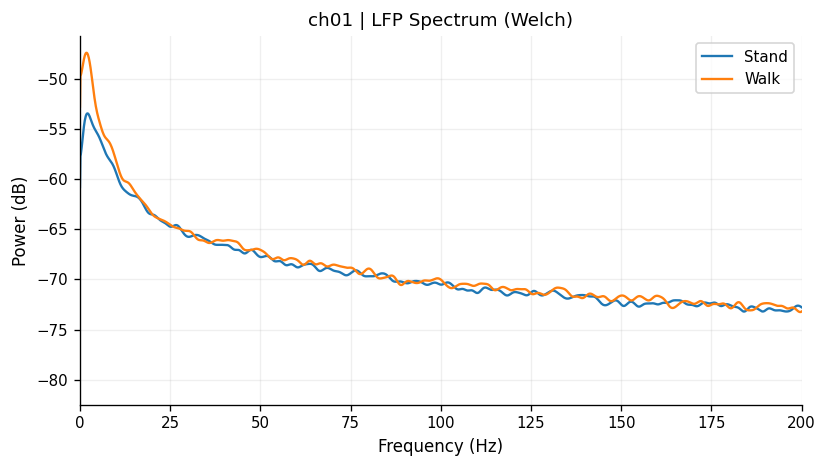

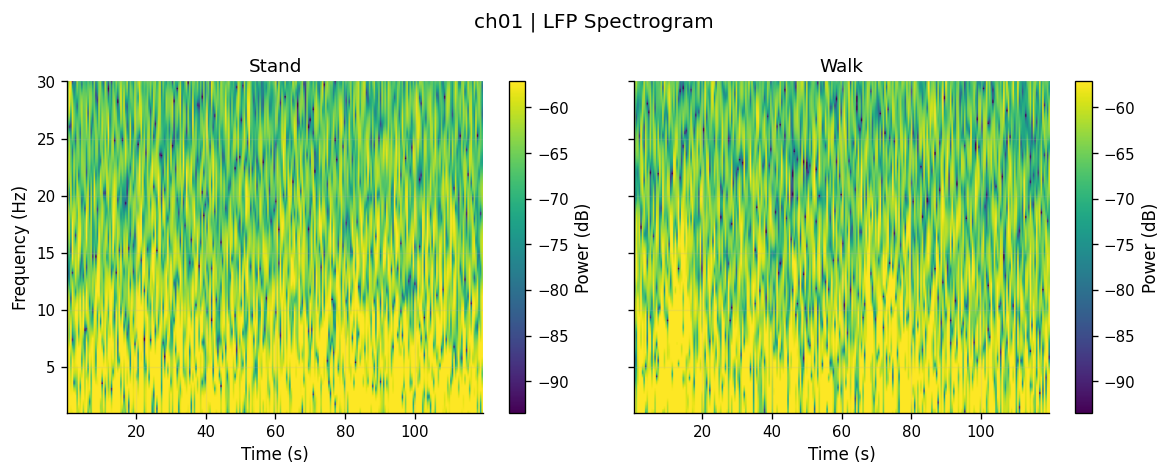

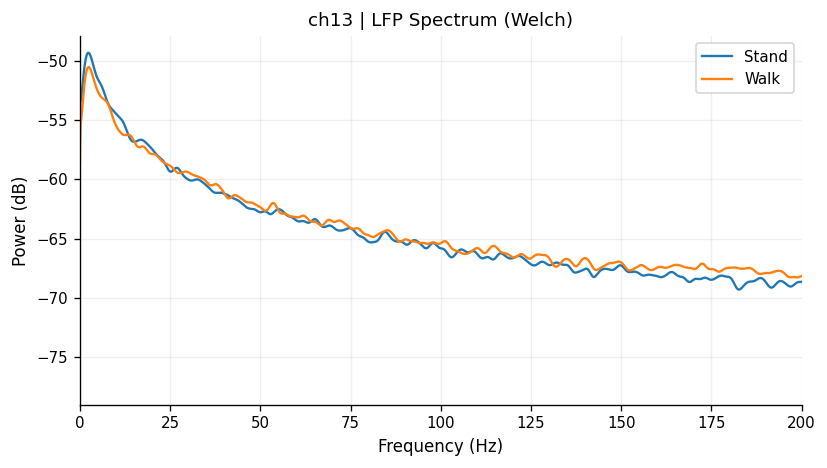

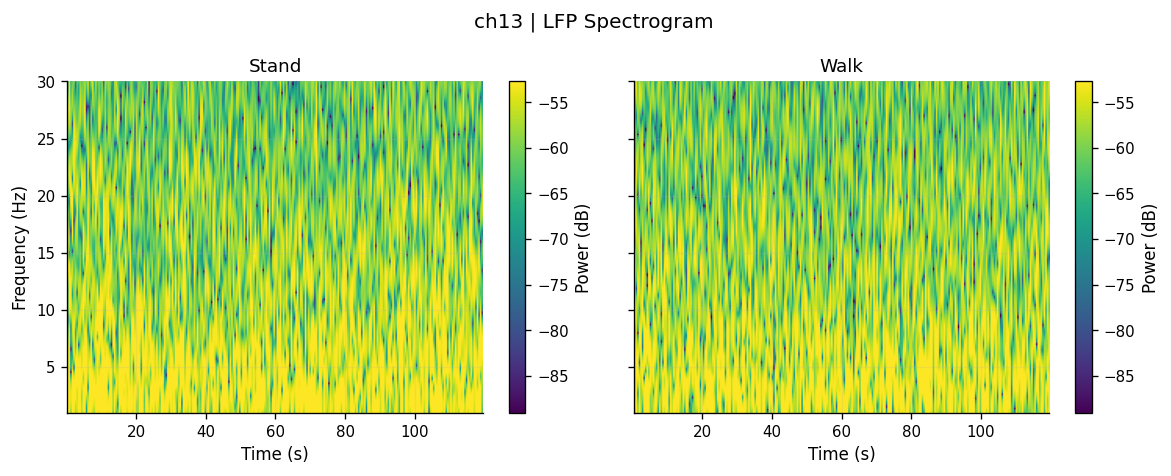

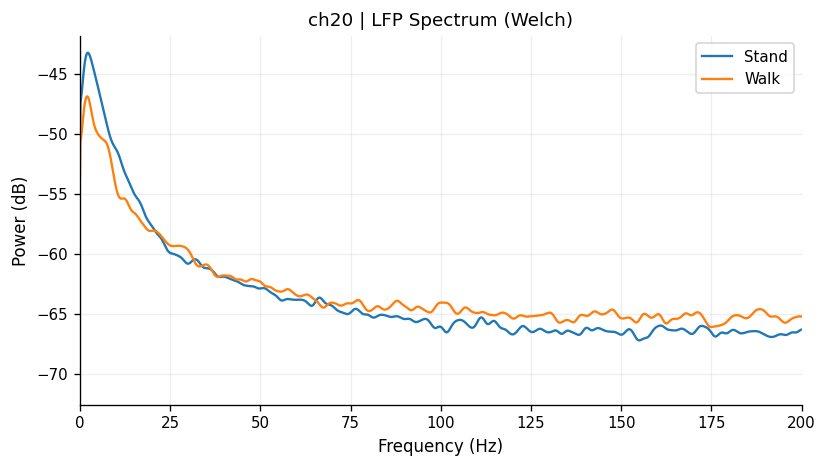

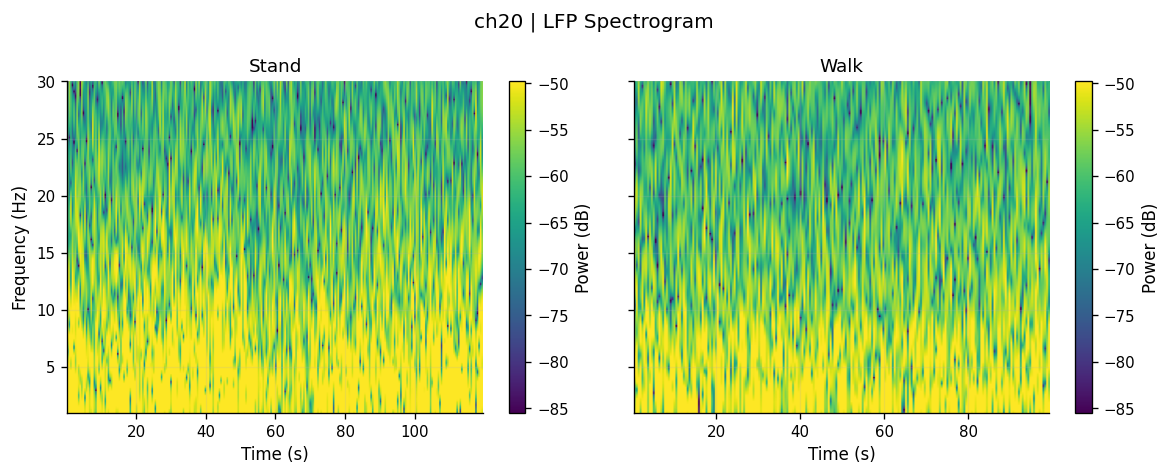

In [50]:
lfp_data = load_mat(LFP_MAT_PATH)
LFP_spectrum(lfp_data, Fs=1000.0, save_prefix="part4_lfp")


Across the three channels, the comparison between Stand and Walk reveals clear but channel-specific spectral modulations rather than a uniform global effect. In ch01, the Walk condition is characterized by a relative enhancement of low-frequency power, visible as a systematic elevation of the spectrum at the lowest frequencies and a generally steeper spectral decay, suggesting increased dominance of slow LFP fluctuations during movement. In contrast, ch13 shows largely overlapping spectra between the two conditions, with only minor broadband deviations and no pronounced redistribution of power across frequencies, indicating minimal sensitivity to the behavioral state. A different pattern emerges in ch20, where the Walk condition exhibits a relative reduction in low-frequency power accompanied by a subtle but consistent elevation at higher frequencies, producing a flatter overall spectral profile. Together, these results indicate that walking induces heterogeneous, channel-dependent changes in LFP dynamics, ranging from low-frequency enhancement to desynchronization-like spectral flattening, rather than a single uniform spectral shift across recording sites.